In [1]:
#!pip install -U statsmodels
#!wget -nc https://lazyprogrammer.me/course_files/timeseries/perrin-freres-monthly-champagne.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score


In [4]:
df = pd.read_csv(
    '../datasets/perrin-freres-monthly-champagne.csv',
    index_col='Month',
    skipfooter=2,
    parse_dates=True)

C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_24384\1848457613.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(


In [6]:
df.head()

,Perrin Freres monthly champagne sales millions ?64-?72
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [7]:
df.columns = ['Sales']

<Axes: xlabel='Month'>

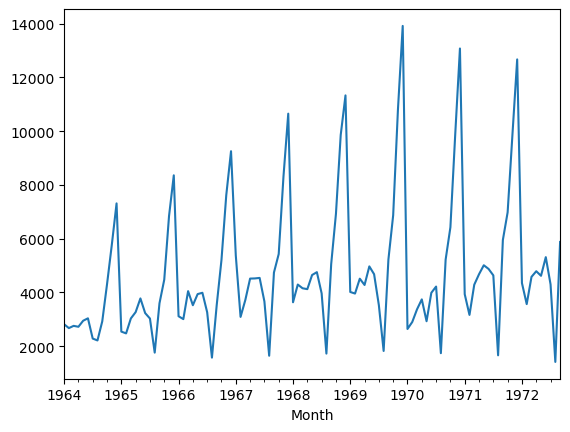

In [8]:
df['Sales'].plot()

In [9]:
df.index.freq = 'MS'

In [19]:
Ntest = 12# how do we define this ? , is it because the seasonal cycle is one year
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [20]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [32]:
train.head()

,Sales,HoltWintersTrain,HoltWintersTest
Month,,,
1964-01-01,2815,2847.166667,NaN
1964-02-01,2672,2733.958369,NaN
1964-03-01,2755,2844.550233,NaN
1964-04-01,2721,2836.104470,NaN
1964-05-01,2946,3084.771330,NaN


try walk forward validation to detect the better parameters for the model

In [25]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [26]:
hw = ExponentialSmoothing(
    train['Sales'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='add', seasonal_periods=12)
res_hw = hw.fit()

In [27]:
df.loc[train_idx, 'HoltWintersTrain'] = res_hw.fittedvalues

In [28]:
df.loc[test_idx, 'HoltWintersTest'] = res_hw.forecast(Ntest)

In [33]:
df.head()

,Sales,HoltWintersTrain,HoltWintersTest
Month,,,
1964-01-01,2815,2847.166667,NaN
1964-02-01,2672,2733.958369,NaN
1964-03-01,2755,2844.550233,NaN
1964-04-01,2721,2836.104470,NaN
1964-05-01,2946,3084.771330,NaN


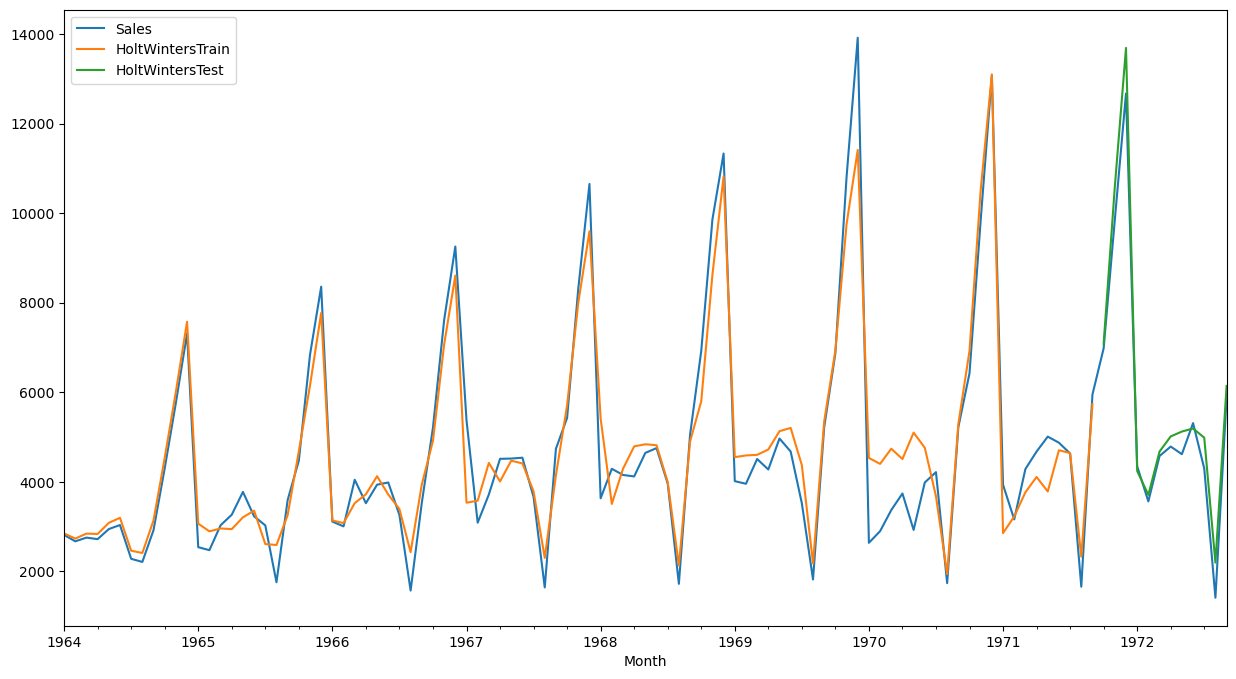

In [29]:
df[['Sales', 'HoltWintersTrain', 'HoltWintersTest']].plot(figsize=(15, 8));

In [30]:
r2_score(train['Sales'], res_hw.fittedvalues)

0.9170005799930573

In [31]:
r2_score(test['Sales'], res_hw.forecast(Ntest))


0.9681244396657379